# INITIALIZATION

In [54]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

In [55]:
# Read data
data = pd.read_csv("dataset.csv")

# Check head
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# PRE-EDA

In [56]:
# Check information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [57]:
# Check null values
missing_values = pd.DataFrame({
        "Columns": data.columns,
        "Missing Values": data.isnull().sum()
}).reset_index(drop=True).sort_values(by="Missing Values", ascending=False)

# Display missing values
missing_values

,Columns,Missing Values
0,Marital status,0
1,Application mode,0
2,Application order,0
3,Course,0
4,Daytime/evening attendance,0
5,Previous qualification,0
6,Nacionality,0
7,Mother's qualification,0
8,Father's qualification,0
9,Mother's occupation,0


No null values; clear to continue.

# PREPROCESSING

## Preprocessing overview

The preprocessing pipeline covers:
0. Column rename
1. Data quality checks (duplicates, empty rows, whitespace)
2. Basic validation (ranges, logical consistency)
3. Feature engineering (success rates, grade change)
4. Class imbalance handling with SMOTE
5. Feature scaling
6. Correlation analysis and optional feature removal
7. Dataset comparisons across stages


## 0. Rename Columns

In [58]:
# rename "Nacionality" to "Nationality"
data.rename(columns={"Nacionality": "Nationality"}, inplace=True)

## 1. Data Cleaning

In [59]:
original_shape = data.shape
print(f"Original dataset shape: {original_shape}")

duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

empty_rows = data.isnull().all(axis=1).sum()
print(f"Number of completely empty rows: {empty_rows}")

string_columns = data.select_dtypes(include=['object']).columns
print(f"\nString columns: {list(string_columns)}")

# Check if there are leading/trailing whitespaces
whitespace_issues = {}
for col in string_columns:
    has_whitespace = data[col].astype(str).str.strip() != data[col].astype(str)
    if has_whitespace.any():
        whitespace_issues[col] = has_whitespace.sum()

if whitespace_issues:
    print("\nColumns with whitespace issues:")
    for col, count in whitespace_issues.items():
        print(f"  {col}: {count} values")
else:
    print("\nNo whitespace issues found.")

Original dataset shape: (4424, 35)

Number of duplicate rows: 0
Number of completely empty rows: 0

String columns: ['Target']

No whitespace issues found.


The dataset is in excellent condition. We verified that there are no duplicate rows, empty rows, or whitespace issues.

## 2. Data Validation

In [60]:
issues = []

# age
age = data["Age at enrollment"]
print("\nAge at enrollment")
print(f"range: {age.min()}–{age.max()}, mean={age.mean():.1f}, median={age.median():.1f}")
print(age.describe())

# curricular units
for sem in ["1st", "2nd"]:
    enrolled = data[f"Curricular units {sem} sem (enrolled)"]
    approved = data[f"Curricular units {sem} sem (approved)"]

    print(f"\nCurricular units ({sem} semester)")
    print(f"enrolled: {enrolled.min()}–{enrolled.max()}")
    print(f"approved: {approved.min()}–{approved.max()}")

    invalid = approved > enrolled
    if invalid.any():
        issues.append(f"{sem} sem: {(invalid).sum()} cases approved > enrolled")

print("\nTarget")
print("classes:", sorted(data["Target"].unique()))
print(data["Target"].value_counts().sort_index())

print("\nNegative value check")
numeric_cols = data.select_dtypes(include=np.number).columns
allowed_negative = {"Unemployment rate", "Inflation rate", "GDP"}

for col in numeric_cols:
    if col in allowed_negative:
        continue
    n_neg = (data[col] < 0).sum()
    if n_neg > 0:
        print(f"{col}: {n_neg} negatives")
        issues.append(f"{col}: {n_neg} negative values")

print("\nValidation issues:")
print(issues if issues else "none")



Age at enrollment
range: 17–70, mean=23.3, median=20.0
count    4424.000000
mean       23.265145
std         7.587816
min        17.000000
25%        19.000000
50%        20.000000
75%        25.000000
max        70.000000
Name: Age at enrollment, dtype: float64

Curricular units (1st semester)
enrolled: 0–26
approved: 0–26

Curricular units (2nd semester)
enrolled: 0–23
approved: 0–20

Target
classes: ['Dropout', 'Enrolled', 'Graduate']
Target
Dropout     1421
Enrolled     794
Graduate    2209
Name: count, dtype: int64

Negative value check

Validation issues:
none


No issues on data validation.

## 3. Feature Engineering

In [61]:
df = data.copy()

# success rates
enrolled_1st = df["Curricular units 1st sem (enrolled)"]
approved_1st = df["Curricular units 1st sem (approved)"]

enrolled_2nd = df["Curricular units 2nd sem (enrolled)"]
approved_2nd = df["Curricular units 2nd sem (approved)"]

df["Success_rate_1st_sem"] = approved_1st.div(
    enrolled_1st.where(enrolled_1st > 0, 1)
)

df["Success_rate_2nd_sem"] = approved_2nd.div(
    enrolled_2nd.where(enrolled_2nd > 0, 1)
)

total_enrolled = enrolled_1st + enrolled_2nd
total_approved = approved_1st + approved_2nd

df["Success_rate_overall"] = total_approved.div(
    total_enrolled.where(total_enrolled > 0, 1)
)

print("Success rates (mean):")
print(
    df[
        ["Success_rate_1st_sem",
         "Success_rate_2nd_sem",
         "Success_rate_overall"]
    ].mean().mul(100).round(2)
)

# grade change
df["Grade_change"] = (
    df["Curricular units 2nd sem (grade)"] -
    df["Curricular units 1st sem (grade)"]
)

print("\nGrade change:")
print({
    "mean": round(df["Grade_change"].mean(), 2),
    "improved": int((df["Grade_change"] > 0).sum()),
    "declined": int((df["Grade_change"] < 0).sum()),
})

data_engineered = df

Success rates (mean):
Success_rate_1st_sem    69.79
Success_rate_2nd_sem    66.04
Success_rate_overall    67.91
dtype: float64

Grade change:
{'mean': np.float64(-0.41), 'improved': 1554, 'declined': 1721}


In [62]:
# keep the feature engineering results, just in case
data_feat_eng = df

## 4. Handling Class Imbalance with SMOTE


Class distribution before SMOTE:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Percentages:
Target
Graduate    49.93
Dropout     32.12
Enrolled    17.95
Name: count, dtype: float64


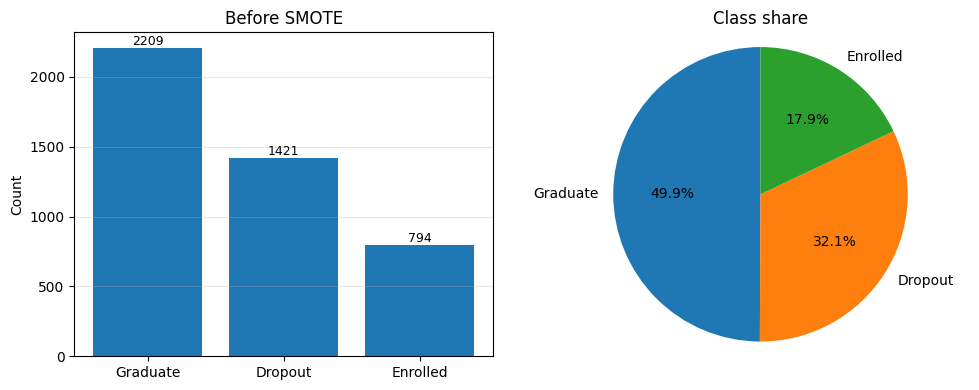

In [63]:
counts = data_engineered["Target"].value_counts()
pct = counts / counts.sum() * 100

print("Class distribution before SMOTE:")
print(counts)
print("\nPercentages:")
print(pct.round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# bar chart
ax1.bar(counts.index, counts.values)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")
ax1.grid(axis="y", alpha=0.3)

for i, v in enumerate(counts.values):
    ax1.text(i, v, v, ha="center", va="bottom", fontsize=9)

# pie chart
ax2.pie(counts.values, labels=counts.index, autopct="%.1f%%", startangle=90)
ax2.set_title("Class share")
ax2.set_ylabel("")
ax2.axis("equal")

plt.tight_layout()
plt.show()


### 4.2 Apply SMOTE

We'll use SMOTE to balance the classes. we should use smote after train/test split.

In [64]:
from imblearn.over_sampling import SMOTE

# numeric-only features for SMOTE
numeric_cols = data_engineered.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop("Target", errors="ignore")

X = data_engineered[numeric_cols]
y = data_engineered["Target"]

print(f"SMOTE features: {len(numeric_cols)}")
print(f"X shape: {X.shape}")
print("Class counts before SMOTE:")
print(y.value_counts(), "\n")

smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE:")
print(f"X_resampled shape: {X_resampled.shape}")
print(pd.Series(y_resampled).value_counts())

data_resampled = X_resampled.copy()
data_resampled["Target"] = y_resampled


SMOTE features: 38
X shape: (4424, 38)
Class counts before SMOTE:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64 

After SMOTE:
X_resampled shape: (6627, 38)
Target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64


Class distribution after SMOTE:
Target
Dropout     2209
Graduate    2209
Enrolled    2209
Name: count, dtype: int64

Percentages:
Target
Dropout     33.33
Graduate    33.33
Enrolled    33.33
Name: count, dtype: float64


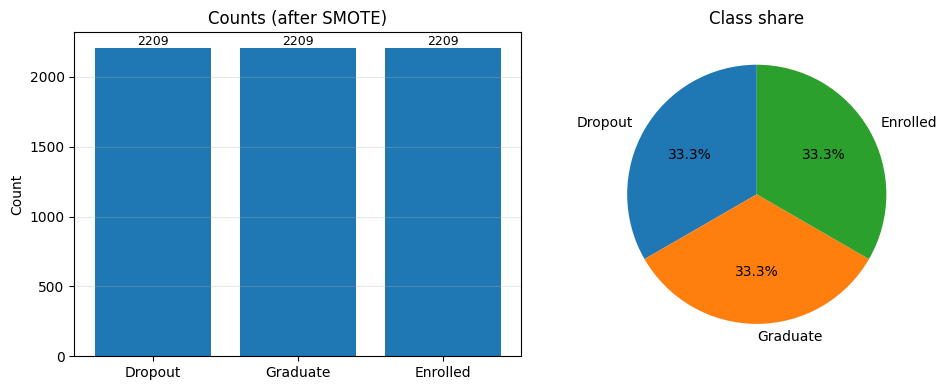

In [65]:
counts = pd.Series(y_resampled).value_counts()
pct = counts / counts.sum() * 100

print("Class distribution after SMOTE:")
print(counts)
print("\nPercentages:")
print(pct.round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# bar chart
ax1.bar(counts.index, counts.values)
ax1.set_title("Counts (after SMOTE)")
ax1.set_ylabel("Count")
ax1.grid(axis="y", alpha=0.3)

for i, v in enumerate(counts.values):
    ax1.text(i, v, v, ha="center", va="bottom", fontsize=9)

# pie chart
ax2.pie(counts.values, labels=counts.index, autopct="%.1f%%", startangle=90)
ax2.set_title("Class share")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()


## 5. Feature Scaling

We apply StandardScaler to normalize features to mean=0 and std=1. For distance algorithms such as neural networks, knn, svm, kmeans, use the scaled versions, but for tree models, xgboost no need to use the scaled variant. 

In [66]:
from sklearn.preprocessing import StandardScaler

df = data_engineered.copy()
y = df.pop("Target")

numeric_cols = df.select_dtypes(include=np.number).columns

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

data_scaled = df.join(y)

# sanity check
stats = data_scaled[numeric_cols].agg(["mean", "std"]).T.round(3)
print("Scaling check (first 10 features):")
print(stats.head(10))


Scaling check (first 10 features):
                            mean  std
Marital status              -0.0  1.0
Application mode            -0.0  1.0
Application order           -0.0  1.0
Course                      -0.0  1.0
Daytime/evening attendance   0.0  1.0
Previous qualification      -0.0  1.0
Nationality                  0.0  1.0
Mother's qualification      -0.0  1.0
Father's qualification       0.0  1.0
Mother's occupation         -0.0  1.0


## 6. Multi-collinearity Analysis

### 6.1 Correlation Analysis

We identify features with high correlation (> 0.7) to see multicollinearity in the dataset

In [67]:
numeric = data.select_dtypes(include=np.number)
corr = numeric.corr()

high_corr = []
important_features = set()

threshold = 0.7

for i, f1 in enumerate(corr.columns):
    for j in range(i + 1, len(corr.columns)):
        f2 = corr.columns[j]
        r = corr.iat[i, j]

        if abs(r) > threshold:
            high_corr.append((f1, f2, r))
            important_features.update([f1, f2])

print(f"High-correlation pairs (|r| > {threshold}):")

if high_corr:
    high_corr_df = (
        pd.DataFrame(high_corr, columns=["f1", "f2", "r"])
          .sort_values("r", key=abs, ascending=False)
    )
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr)}")
else:
    print("None found.")


High-correlation pairs (|r| > 0.7):
                                    f1                                     f2        r
   Curricular units 1st sem (credited)    Curricular units 2nd sem (credited) 0.944811
   Curricular units 1st sem (enrolled)    Curricular units 2nd sem (enrolled) 0.942627
                           Nationality                          International 0.911724
   Curricular units 1st sem (approved)    Curricular units 2nd sem (approved) 0.904002
      Curricular units 1st sem (grade)       Curricular units 2nd sem (grade) 0.837170
Curricular units 1st sem (evaluations) Curricular units 2nd sem (evaluations) 0.778863
   Curricular units 1st sem (credited)    Curricular units 1st sem (enrolled) 0.774344
   Curricular units 1st sem (enrolled)    Curricular units 1st sem (approved) 0.769083
   Curricular units 2nd sem (approved)       Curricular units 2nd sem (grade) 0.760804
   Curricular units 1st sem (enrolled)    Curricular units 2nd sem (credited) 0.753747
   Curr

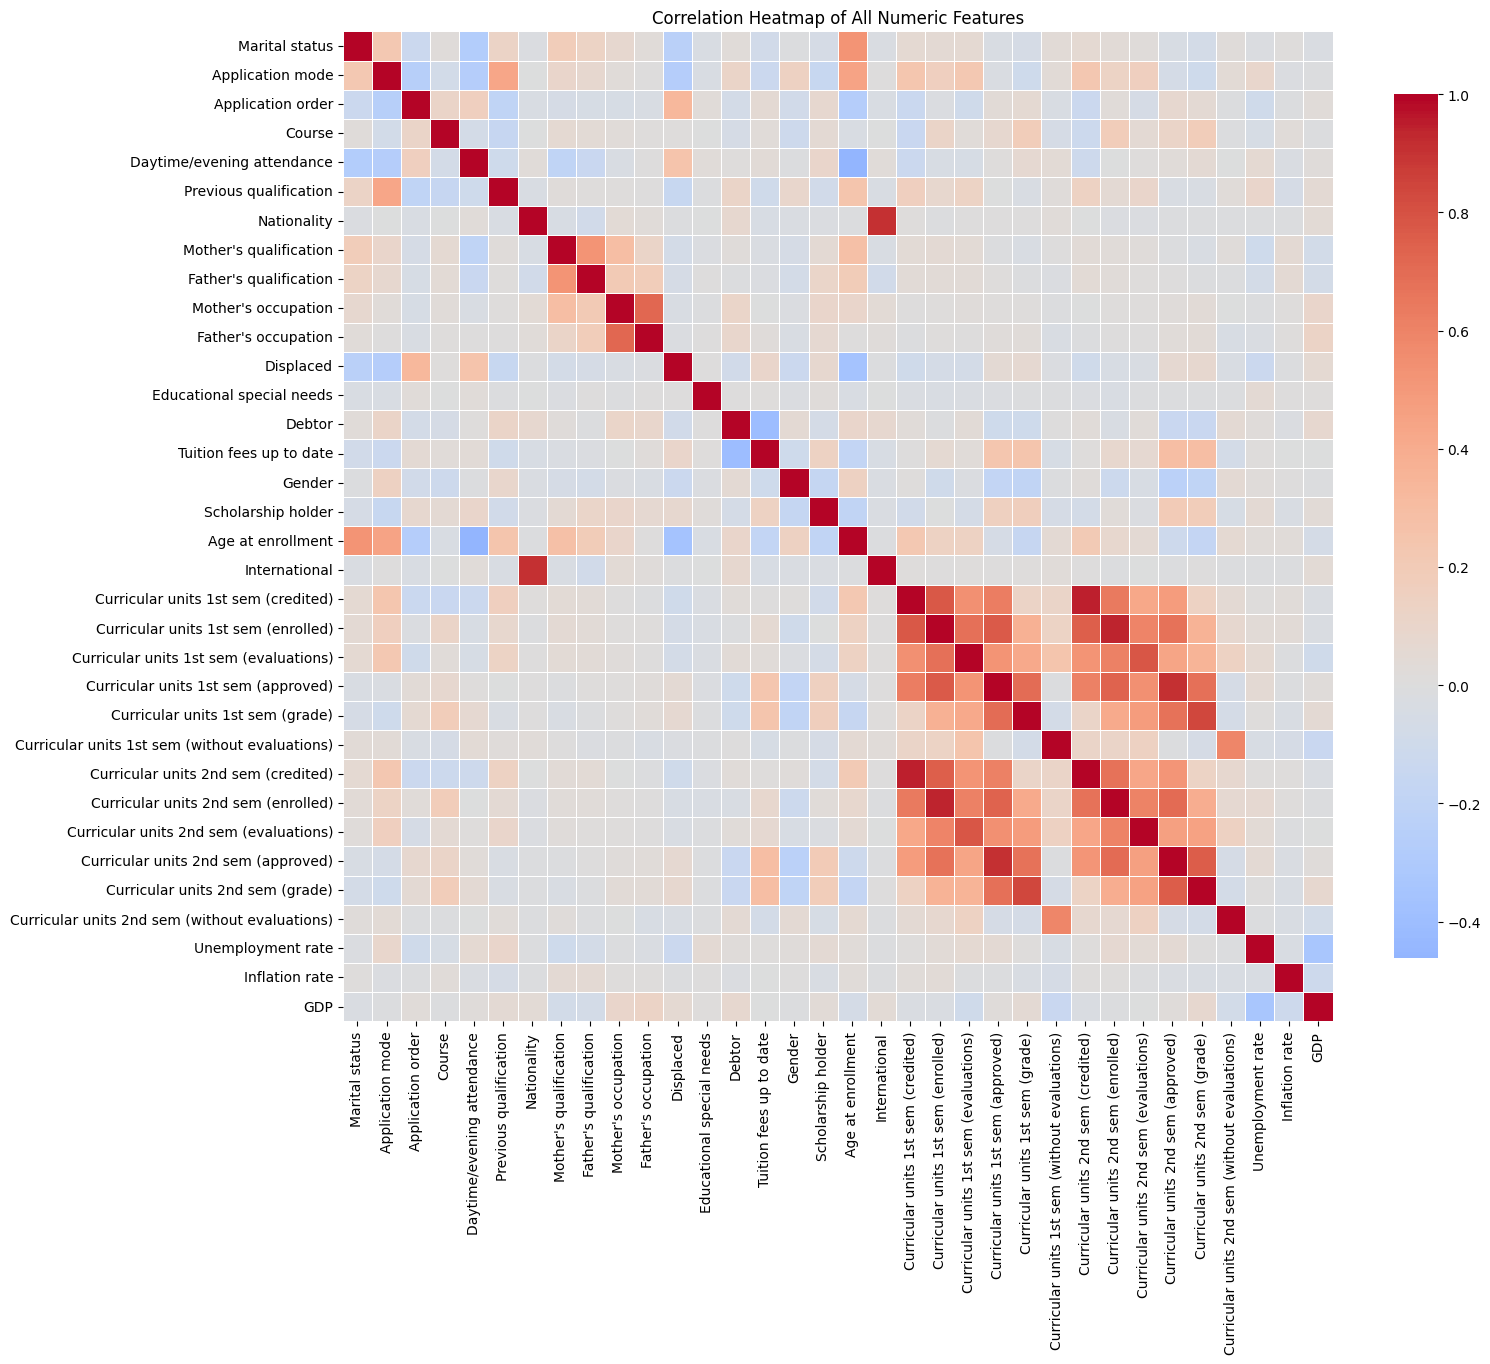

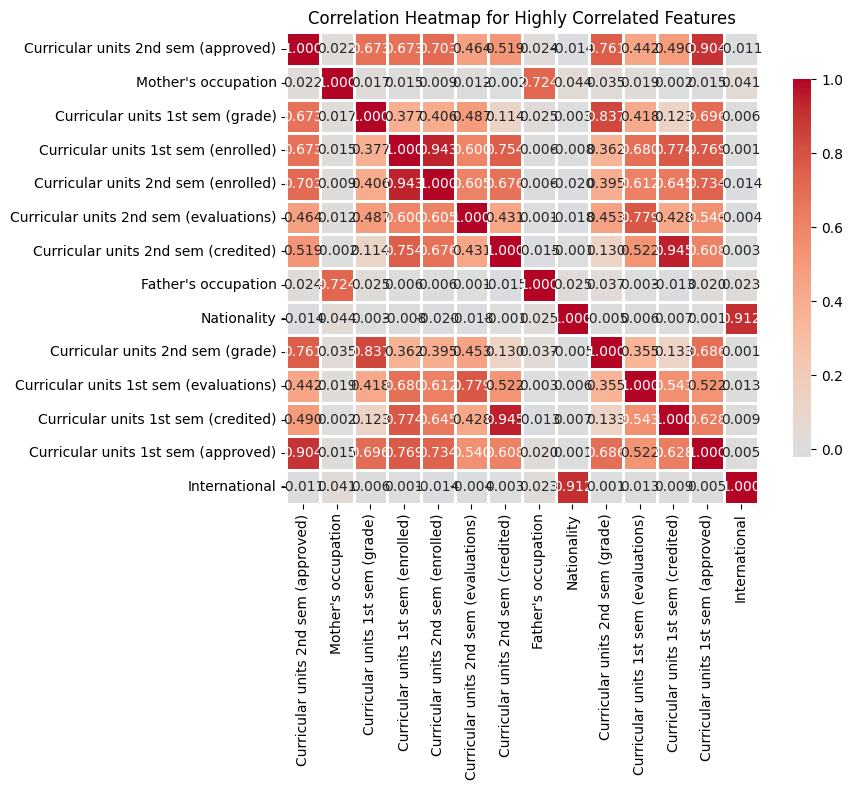

In [68]:
# Visualize correlation heatmap for highly correlated features
plt.figure(figsize=(16, 14))

# Create heatmap
sns.heatmap(corr, 
            cmap='coolwarm', 
            center=0,
            annot=False,
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of All Numeric Features')
plt.tight_layout()
plt.show()

important_features = list(important_features)
corr_subset = data[important_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_subset, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap for Highly Correlated Features')
plt.tight_layout()
plt.show()

### 6.2 Drop Highly Correlated Features

Now we'll drop one feature from each highly correlated pair to reduce multicollinearity:

In [69]:
DROP_CORRELATED_FEATURES = True

if not DROP_CORRELATED_FEATURES:
    print("Skipping correlation-based feature drop")
else:
    data_reduced = data_engineered.copy()

    # Separate target if present
    target = None
    if 'Target' in data_reduced.columns:
        target = data_reduced.pop('Target')

    # Correlation on numeric features only
    numeric_cols = data_reduced.select_dtypes(include=np.number)
    corr = numeric_cols.corr().abs()

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if (upper[col] > 0.7).any()]

    if to_drop:
        print("Dropping highly correlated features:")
        for col in to_drop:
            offenders = upper[col][upper[col] > 0.7]
            for other, r in offenders.items():
                print(f"  {col} - {other} (r={r:.2f})")
    else:
        print("No highly correlated features found")

    data_reduced.drop(columns=to_drop, inplace=True)

    if target is not None:
        data_reduced['Target'] = target

    print(f"Features: {data_engineered.shape[1]} → {data_reduced.shape[1]}")

    data_engineered = data_reduced


Dropping highly correlated features:
  Father's occupation - Mother's occupation (r=0.72)
  International - Nationality (r=0.91)
  Curricular units 1st sem (enrolled) - Curricular units 1st sem (credited) (r=0.77)
  Curricular units 1st sem (approved) - Curricular units 1st sem (enrolled) (r=0.77)
  Curricular units 2nd sem (credited) - Curricular units 1st sem (credited) (r=0.94)
  Curricular units 2nd sem (credited) - Curricular units 1st sem (enrolled) (r=0.75)
  Curricular units 2nd sem (enrolled) - Curricular units 1st sem (enrolled) (r=0.94)
  Curricular units 2nd sem (enrolled) - Curricular units 1st sem (approved) (r=0.73)
  Curricular units 2nd sem (evaluations) - Curricular units 1st sem (evaluations) (r=0.78)
  Curricular units 2nd sem (approved) - Curricular units 1st sem (approved) (r=0.90)
  Curricular units 2nd sem (approved) - Curricular units 2nd sem (enrolled) (r=0.70)
  Curricular units 2nd sem (grade) - Curricular units 1st sem (grade) (r=0.84)
  Curricular units 2n

## 7. Before and After Comparison

In [70]:
rows = [
    ("Samples", data.shape[0], data_engineered.shape[0], data_resampled.shape[0]),
    ("Features", data.shape[1], data_engineered.shape[1], data_resampled.shape[1]),
    ("Missing values", data.isnull().sum().sum(), data_engineered.isnull().sum().sum(), data_resampled.isnull().sum().sum()),
    ("Duplicates", data.duplicated().sum(), data_engineered.duplicated().sum(), data_resampled.duplicated().sum()),
    ("Target classes", data["Target"].nunique(), data_engineered["Target"].nunique(), data_resampled["Target"].nunique()),
]

def imbalance_ratio(df):
    vc = df["Target"].value_counts()
    return vc.max() / vc.min()

rows += [
    ("Imbalance ratio", imbalance_ratio(data), imbalance_ratio(data_engineered), imbalance_ratio(data_resampled)),
    ("Graduate", (data["Target"] == "Graduate").sum(),
                  (data_engineered["Target"] == "Graduate").sum(),
                  (data_resampled["Target"] == "Graduate").sum()),
    ("Dropout", (data["Target"] == "Dropout").sum(),
                 (data_engineered["Target"] == "Dropout").sum(),
                 (data_resampled["Target"] == "Dropout").sum()),
    ("Enrolled", (data["Target"] == "Enrolled").sum(),
                  (data_engineered["Target"] == "Enrolled").sum(),
                  (data_resampled["Target"] == "Enrolled").sum()),
]

comparison_df = pd.DataFrame(
    rows,
    columns=["Metric", "Original", "Engineered", "SMOTE"]
)

comparison_df


,Metric,Original,Engineered,SMOTE
0,Samples,4424.000000,4424.000000,6627.0
1,Features,35.000000,27.000000,39.0
2,Missing values,0.000000,0.000000,0.0
3,Duplicates,0.000000,1.000000,3.0
4,Target classes,3.000000,3.000000,3.0
5,Imbalance ratio,2.782116,2.782116,1.0
6,Graduate,2209.000000,2209.000000,2209.0
7,Dropout,1421.000000,1421.000000,2209.0
8,Enrolled,794.000000,794.000000,2209.0


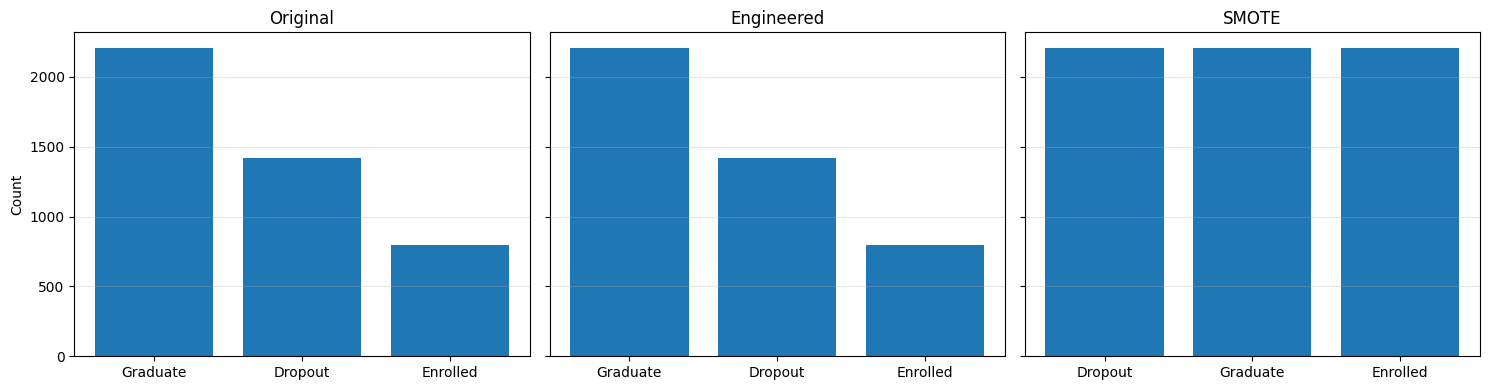

In [71]:
# visualize class distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

datasets = [
    ("Original", data["Target"]),
    ("Engineered", data_engineered["Target"]),
    ("SMOTE", pd.Series(y_resampled)),
]

for ax, (name, target) in zip(axes, datasets):
    counts = target.value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(name)
    ax.grid(axis="y", alpha=0.3)

axes[0].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [72]:
from pathlib import Path

out_dir = Path("preprocessed_data")
out_dir.mkdir(exist_ok=True)

datasets = {
    "dataset_cleaned.csv": data,
    "dataset_engineered.csv": data_engineered,
    "dataset_feat_eng.csv": data_feat_eng,
    "dataset_smote_balanced.csv": data_resampled,
    "dataset_scaled.csv": data_scaled,
}

for name, df in datasets.items():
    df.to_csv(out_dir / name, index=False)

print(f"Saved {len(datasets)} datasets to {out_dir}/")


Saved 5 datasets to preprocessed_data/


## Preprocessing Summary

**Cleaning & validation**
- Dataset was already clean: no missing values, no duplicates.
- Value ranges and encodings checked (age, grades, units).
- No corrective cleaning steps needed.

**Feature engineering**
- Added derived features:
  - Semester-level success rates to normalize performance by course load
  - Grade delta between semesters to capture trajectory

**Multicollinearity**
- Highly correlated features (|r| > 0.7) identified.
- Redundant features dropped

**Class imbalance**
- Original target distribution was moderately imbalanced.
- SMOTE used

**Scaling**
- Standard scaling applied to numerical features.

### Available datasets
- `dataset_cleaned.csv`: validated original data
- `dataset_engineered.csv`: engineered features (optionally reduced)
- `dataset_smote_balanced.csv`: balanced training set
- `dataset_scaled.csv`: scaled version for distance-based models


## Convert Numbers to Strings (Better Interpretability; Only for EDA purposes)

In [ ]:
# Convert marital status to categorical
data['Marital status_cat'] = data['Marital status'].map({
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
})

In [ ]:
# Convert nationality to categorical
data['Nationality_cat'] = data['Nationality'].map({
    1: 'Portuguese',
    2: 'German',
    3: 'Spanish',
    4: 'Italian',
    5: 'Dutch',
    6: 'English',
    7: 'Lithuanian',
    8: 'Angolan',
    9: 'Cape Verdean',
    10: 'Guinean',
    11: 'Mozambican',
    12: 'Santomean',
    13: 'Turkish',
    14: 'Brazilian',
    15: 'Romanian',
    16: 'Moldova (Republic of)',
    17: 'Mexican',
    18: 'Ukrainian',
    19: 'Russian',
    20: 'Cuban',
    21: 'Colombian'
})

In [ ]:
# Convert application mode to categorical
data['Application mode_cat'] = data['Application mode'].map({
    1: '1—1st phase—general contingent',
    2: '2—Ordinance No. 612/93',
    3: '3—1st phase—special contingent (Azores Island)',
    4: '4—Holders of other higher courses',
    5: '5—Ordinance No. 854-B/99',
    6: '6—International student (bachelor)',
    7: '7—1st phase—special contingent (Madeira Island)',
    8: '8—2nd phase—general contingent',
    9: '9—3rd phase—general contingent',
    10: '10—Ordinance No. 533-A/99, item b2) (Different Plan)',
    11: '11—Ordinance No. 533-A/99, item b3 (Other Institution)',
    12: '12—Over 23 years old',
    13: '13—Transfer',
    14: '14—Change in course',
    15: '15—Technological specialization diploma holders',
    16: '16—Change in institution/course',
    17: '17—Short cycle diploma holders',
    18: '18—Change in institution/course (International)'
})

In [ ]:
# Convert course to categorical
data['Course_cat'] = data['Course'].map({
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening attendance)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equiniculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening attendance)'
})

In [ ]:
# Convert previous qualification to categorical
data['Previous qualification_cat'] = data['Previous qualification'].map({
    1: 'Secondary education',
    2: 'Higher education—bachelor\'s degree',
    3: 'Higher education—degree',
    4: 'Higher education—master\'s degree',
    5: 'Higher education—doctorate',
    6: 'Frequency of higher education',
    7: '12th year of schooling—not completed',
    8: '11th year of schooling—not completed',
    9: 'Other—11th year of schooling',
    10: '10th year of schooling',
    11: '10th year of schooling—not completed',
    12: 'Basic education 3rd cycle (9th/10th/11th year) or equivalent',
    13: 'Basic education 2nd cycle (6th/7th/8th year) or equivalent',
    14: 'Technological specialization course',
    15: 'Higher education—degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education—master\'s degree (2nd cycle)'
})

In [ ]:
# Convert mother's qualification to categorical
data['Mother qualification_cat'] = data['Mother\'s qualification'].map({
    1: 'Secondary Education—12th Year of Schooling or Equivalent',
    2: 'Higher Education—bachelor\'s degree',
    3: 'Higher Education—degree',
    4: 'Higher Education—master\'s degree',
    5: 'Higher Education—doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling—not completed',
    8: '11th Year of Schooling—not completed',
    9: '7th Year (Old)',
    10: 'Other—11th Year of Schooling',
    11: '2nd year complementary high school course',
    12: '10th Year of Schooling',
    13: 'General commerce course',
    14: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',
    15: 'Complementary High School Course',
    16: 'Technical-professional course',
    17: 'Complementary High School Course—not concluded',
    18: '7th year of schooling',
    19: '2nd cycle of the general high school course',
    20: '9th Year of Schooling—not completed',
    21: '8th year of schooling',
    22: 'General Course of Administration and Commerce',
    23: 'Supplementary Accounting and Administration',
    24: 'Unknown',
    25: 'Cannot read or write',
    26: 'Can read without having a 4th year of schooling',
    27: 'Basic education 1st cycle (4th/5th year) or equivalent',
    28: 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent',
    29: 'Technological specialization course',
    30: 'Higher education—degree (1st cycle)',
    31: 'Specialized higher studies course',
    32: 'Professional higher technical course',
    33: 'Higher Education—master\'s degree (2nd cycle)',
    34: 'Higher Education—doctorate (3rd cycle)'
})

In [ ]:
# Convert father's qualification to categorical
data['Father qualification_cat'] = data['Father\'s qualification'].map({
    1: 'Secondary Education—12th Year of Schooling or Equivalent',
    2: 'Higher Education—bachelor\'s degree',
    3: 'Higher Education—degree',
    4: 'Higher Education—master\'s degree',
    5: 'Higher Education—doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling—not completed',
    8: '11th Year of Schooling—not completed',
    9: '7th Year (Old)',
    10: 'Other—11th Year of Schooling',
    11: '2nd year complementary high school course',
    12: '10th Year of Schooling',
    13: 'General commerce course',
    14: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',
    15: 'Complementary High School Course',
    16: 'Technical-professional course',
    17: 'Complementary High School Course—not concluded',
    18: '7th year of schooling',
    19: '2nd cycle of the general high school course',
    20: '9th Year of Schooling—not completed',
    21: '8th year of schooling',
    22: 'General Course of Administration and Commerce',
    23: 'Supplementary Accounting and Administration',
    24: 'Unknown',
    25: 'Cannot read or write',
    26: 'Can read without having a 4th year of schooling',
    27: 'Basic education 1st cycle (4th/5th year) or equivalent',
    28: 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent',
    29: 'Technological specialization course',
    30: 'Higher education—degree (1st cycle)',
    31: 'Specialized higher studies course',
    32: 'Professional higher technical course',
    33: 'Higher Education—master\'s degree (2nd cycle)',
    34: 'Higher Education—doctorate (3rd cycle)'
})

In [ ]:
# Convert mother's occupation to categorical
data['Mother_occupation_cat'] = data["Mother's occupation"].map({
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers, and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries, and Forestry',
    8: 'Skilled Workers in Industry, Construction, and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: '-',
    14: 'Armed Forces Officers',
    15: 'Armed Forces Sergeants',
    16: 'Other Armed Forces personnel',
    17: 'Directors of administrative and commercial services',
    18: 'Hotel, catering, trade, and other services directors',
    19: 'Specialists in the physical sciences, mathematics, engineering, and related techniques',
    20: 'Health professionals',
    21: 'Teachers',
    22: 'Specialists in finance, accounting, administrative organization, and public and commercial relations',
    23: 'Intermediate level science and engineering technicians and professions',
    24: 'Technicians and professionals of intermediate level of health',
    25: 'Intermediate level technicians from legal, social, sports, cultural, and similar services',
    26: 'Information and communication technology technicians',
    27: 'Office workers, secretaries in general, and data processing operators',
    28: 'Data, accounting, statistical, financial services, and registry-related operators',
    29: 'Other administrative support staff',
    30: 'Personal service workers',
    31: 'Sellers',
    32: 'Personal care workers and the like',
    33: 'Protection and security services personnel',
    34: 'Market-oriented farmers and skilled agricultural and animal production workers',
    35: 'Farmers, livestock keepers, fishermen, hunters and gatherers, and subsistence',
    36: 'Skilled construction workers and the like, except electricians',
    37: 'Skilled workers in metallurgy, metalworking, and similar',
    38: 'Skilled workers in electricity and electronics',
    39: 'Workers in food processing, woodworking, and clothing and other industries and crafts',
    40: 'Fixed plant and machine operators',
    41: 'Assembly workers',
    42: 'Vehicle drivers and mobile equipment operators',
    43: 'Unskilled workers in agriculture, animal production, and fisheries and forestry',
    44: 'Unskilled workers in extractive industry, construction, manufacturing, and transport',
    45: 'Meal preparation assistants',
    46: 'Street vendors (except food) and street service providers'
})

In [ ]:
# Convert father's occupation to categorical
data['Father_occupation_cat'] = data["Father's occupation"].map({
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers, and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries, and Forestry',
    8: 'Skilled Workers in Industry, Construction, and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: '-',
    14: 'Armed Forces Officers',
    15: 'Armed Forces Sergeants',
    16: 'Other Armed Forces personnel',
    17: 'Directors of administrative and commercial services',
    18: 'Hotel, catering, trade, and other services directors',
    19: 'Specialists in the physical sciences, mathematics, engineering, and related techniques',
    20: 'Health professionals',
    21: 'Teachers',
    22: 'Specialists in finance, accounting, administrative organization, and public and commercial relations',
    23: 'Intermediate level science and engineering technicians and professions',
    24: 'Technicians and professionals of intermediate level of health',
    25: 'Intermediate level technicians from legal, social, sports, cultural, and similar services',
    26: 'Information and communication technology technicians',
    27: 'Office workers, secretaries in general, and data processing operators',
    28: 'Data, accounting, statistical, financial services, and registry-related operators',
    29: 'Other administrative support staff',
    30: 'Personal service workers',
    31: 'Sellers',
    32: 'Personal care workers and the like',
    33: 'Protection and security services personnel',
    34: 'Market-oriented farmers and skilled agricultural and animal production workers',
    35: 'Farmers, livestock keepers, fishermen, hunters and gatherers, and subsistence',
    36: 'Skilled construction workers and the like, except electricians',
    37: 'Skilled workers in metallurgy, metalworking, and similar',
    38: 'Skilled workers in electricity and electronics',
    39: 'Workers in food processing, woodworking, and clothing and other industries and crafts',
    40: 'Fixed plant and machine operators',
    41: 'Assembly workers',
    42: 'Vehicle drivers and mobile equipment operators',
    43: 'Unskilled workers in agriculture, animal production, and fisheries and forestry',
    44: 'Unskilled workers in extractive industry, construction, manufacturing, and transport',
    45: 'Meal preparation assistants',
    46: 'Street vendors (except food) and street service providers'
})

In [ ]:
# Convert gender to categorical
data['Gender_cat'] = data['Gender'].map({
    1: 'Male',
    0: 'Female'
})

In [ ]:
# Convert daytime/evening attendance to categorical
data['Daytime/evening attendance_cat'] = data['Daytime/evening attendance'].map({
    1: 'Daytime',
    0: 'Evening'
})

In [ ]:
# Convert 1-0 to Yes-No
data['Displaced_cat'] = data['Displaced'].map({
    1: 'Yes',
    0: 'No'
})
data['Educational_special_needs_cat'] = data['Educational special needs'].map({
    1: 'Yes',
    0: 'No'
})
data['Debtor_cat'] = data['Debtor'].map({
    1: 'Yes',
    0: 'No'
})
data['Tuition_fees_up_to_date_cat'] = data['Tuition fees up to date'].map({
    1: 'Yes',
    0: 'No'
})
data['Scholarship_holder_cat'] = data['Scholarship holder'].map({
    1: 'Yes',
    0: 'No'
})
data['International_cat'] = data['International'].map({
    1: 'Yes',
    0: 'No'
})

## Convert Strings to Category

In [ ]:
# Convert target variable to categorical
data['Target_cat'] = data['Target'].map({
    'Graduate': 2,
    'Dropout': 0,
    'Enrolled': 1
})

# EDA

In [ ]:
# Determine ideal number of bins using Freedman-Diaconis rule
def freedman_diaconis_rule(data_series):
    q75, q25 = np.percentile(data_series.dropna(), [75 ,25])
    iqr = q75 - q25
    bin_width = 2 * iqr * (len(data_series.dropna()) ** (-1/3))
    num_bins = int((data_series.max() - data_series.min()) / bin_width)
    return max(1, num_bins)  # Ensure at least 1 bin

num_bins_1st_sem = freedman_diaconis_rule(data['Curricular units 1st sem (grade)'])
num_bins_2nd_sem = freedman_diaconis_rule(data['Curricular units 2nd sem (grade)'])

print(f'Ideal number of bins for 1st semester grades: {num_bins_1st_sem}')
print(f'Ideal number of bins for 2nd semester grades: {num_bins_2nd_sem}')

In [ ]:
# Visualize grade distribution for 1st semester
plt.figure(figsize=(10,6))
sns.histplot(data['Curricular units 1st sem (grade)'], bins=num_bins_1st_sem, kde=True)
plt.title('Distribution of Curricular Units 1st Sem (Grade)')
plt.xlabel('Grade')
plt.ylabel('Frequency')
# Add red vertical line at 10
plt.axvline(x=10, color='red', linestyle='--', label='Passing Grade (10)')
plt.show()

print("Students with scores below 10 in 1st semester: " + str(len(data[data['Curricular units 1st sem (grade)'] < 10])))

In [ ]:
# Visualize grade distribution for 2nd semester
plt.figure(figsize=(10,6))
sns.histplot(data['Curricular units 2nd sem (grade)'], bins=num_bins_2nd_sem, kde=True)
plt.title('Distribution of Curricular Units 2nd Sem (Grade)')
plt.xlabel('Grade')
plt.ylabel('Frequency')
# Add red vertical line at 10
plt.axvline(x=10, color='red', linestyle='--', label='Passing Grade (10)')
plt.show()

print("Students with scores below 10 in 2nd semester: " + str(len(data[data['Curricular units 2nd sem (grade)'] < 10])))

In [ ]:
# Visualize target distribution
plt.figure(figsize=(10,6))
target_counts = data['Target'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
plt.bar(target_counts.index, target_counts.values, color=colors, edgecolor='black', linewidth=1.5)

# Graph informations
plt.title('Distribution of Student Status (Target)', fontsize=16, fontweight='bold')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for i, (status, count) in enumerate(target_counts.items()):
    plt.text(i, count + 20, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Display statistics
print(f"Total students: {len(data)}")
print(f"Dropout rate: {(target_counts.get('Dropout', 0) / len(data) * 100):.2f}%")
print(f"Graduate rate: {(target_counts.get('Graduate', 0) / len(data) * 100):.2f}%")
print(f"Enrolled rate: {(target_counts.get('Enrolled', 0) / len(data) * 100):.2f}%")

In [ ]:
# Visualize target per age distribution
plt.figure(figsize=(12,6))
for target_status in data['Target'].unique():
    subset = data[data['Target'] == target_status]
    plt.hist(subset['Age at enrollment'], bins=20, alpha=0.6, label=target_status, edgecolor='black')

# Graph informations
plt.title('Age Distribution by Student Status', fontsize=16, fontweight='bold')
plt.xlabel('Age at Enrollment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Status', fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Summary statistics
print("Age Statistics by Target Status:")
print(data.groupby('Target')['Age at enrollment'].describe()[['mean', 'std', 'min', 'max']])

In [ ]:
# Heatmap of features and targets

# Select features
academic_cols = [
    'Previous qualification',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
    'Target_cat'
]

# Calculate correlation matrix
corr_matrix = data[academic_cols].corr()

# Create heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Academic and Economic Indicators', fontsize=16, fontweight='bold', pad=20)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Target distribution per course
course_target = pd.crosstab(data['Course_cat'], data['Target'], normalize='index') * 100

# Sort by graduate percentage in an ascending manner
course_target_sorted = course_target.sort_values(by='Graduate', ascending=True)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(14, 10))
course_target_sorted.plot(kind='barh', stacked=True, ax=ax, 
                          color={'Dropout': '#ff6b6b', 'Enrolled': '#4ecdc4', 'Graduate': '#45b7d1'},
                          edgecolor='black', linewidth=0.5)

# Add percentage labels in the middle of each bar segment
for i, course in enumerate(course_target_sorted.index):
    cumulative = 0
    for status in ['Dropout', 'Enrolled', 'Graduate']:
        if status in course_target_sorted.columns:
            value = course_target_sorted.loc[course, status]
            if value > 3:  # Only show label if segment is large enough
                label_position = cumulative + value / 2
                ax.text(label_position, i, f'{value:.2f}%', 
                       ha='center', va='center', fontsize=9, fontweight='bold', color='black')
            cumulative += value

# Graph informations
plt.title('Student Status Distribution by Course (Sorted by Graduate %)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Course', fontsize=12)
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Display the actual percentages
print("\nTarget Distribution by Course (sorted by Graduate %):")
print("="*80)
course_target_display = course_target_sorted.round(2)
print(course_target_display.to_string())

# Show the count of students per course (statistics)
print("\n\nStudent Count by Course:")
print("="*80)
course_counts = data['Course_cat'].value_counts().loc[course_target_sorted.index]
print(course_counts.to_string())

In [ ]:
# Visualize target per age distribution (animation)
data['Age_Group'] = pd.cut(data['Age at enrollment'], 
                           bins=[17, 20, 25, 30, 35, 40, 100],
                           labels=['18-20', '21-25', '26-30', '31-35', '36-40', '40+'])

# Prepare data for animation
age_anim_data = []
for age_group in ['18-20', '21-25', '26-30', '31-35', '36-40', '40+']:
    for target in data['Target'].unique():
        subset = data[(data['Age_Group'] == age_group) & (data['Target'] == target)]
        if len(subset) > 0:
            age_anim_data.append({
                'Age_Group': age_group,
                'Target': target,
                'Avg_1st_Sem_Grade': subset['Curricular units 1st sem (grade)'].mean(),
                'Avg_2nd_Sem_Grade': subset['Curricular units 2nd sem (grade)'].mean(),
                'Avg_Approved_1st': subset['Curricular units 1st sem (approved)'].mean(),
                'Avg_Approved_2nd': subset['Curricular units 2nd sem (approved)'].mean(),
                'Count': len(subset),
                'Dropout_Rate': (subset['Target'] == 'Dropout').sum() / len(subset) * 100
            })

df_age_anim = pd.DataFrame(age_anim_data)

# Create animated bubble chart
fig = px.scatter(df_age_anim,
                 x='Avg_Approved_1st',
                 y='Avg_1st_Sem_Grade',
                 animation_frame='Age_Group',
                 color='Target',
                 size='Count',
                 hover_name='Target',
                 hover_data={
                     'Avg_Approved_1st': ':.2f',
                     'Avg_1st_Sem_Grade': ':.2f',
                     'Count': True,
                     'Target': False
                 },
                 title='Academic Performance Evolution Across Age Groups',
                 labels={
                     'Avg_Approved_1st': 'Average Approved Units (1st Sem)',
                     'Avg_1st_Sem_Grade': 'Average Grade (1st Sem)',
                     'Target': 'Status'
                 },
                 color_discrete_map={'Dropout': '#ff6b6b', 'Enrolled': '#4ecdc4', 'Graduate': '#45b7d1'},
                 size_max=60)

# Graph informations
fig.update_layout(
    width=1000,
    height=600,
    font=dict(size=12),
    title_font_size=16,
    xaxis=dict(range=[0, df_age_anim['Avg_Approved_1st'].max() + 1]),
    yaxis=dict(range=[0, df_age_anim['Avg_1st_Sem_Grade'].max() + 2])
)

fig.show()

# Statistics
print("\nSummary: Academic Performance by Age Group")
print("="*80)
print(df_age_anim.pivot_table(
    values=['Avg_1st_Sem_Grade', 'Count'],
    index='Age_Group',
    columns='Target',
    aggfunc='mean'
).round(2))

In [ ]:
# Visualize correlation of mother's qualification towards target

# Get the unique mother qualification categories that exist in the data
mother_qual_categories = sorted(data['Mother qualification_cat'].dropna().unique())

# Define logical ordering for education levels (lowest to highest)
education_order = [
    'Cannot read or write',
    'Can read without having a 4th year of schooling',
    'Basic education 1st cycle (4th/5th year) or equivalent',
    'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent',
    '7th year of schooling',
    '7th Year (Old)',
    '8th year of schooling',
    '9th Year of Schooling—not completed',
    'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',
    '10th Year of Schooling',
    '11th Year of Schooling—not completed',
    'Other—11th Year of Schooling',
    '12th Year of Schooling—not completed',
    'Secondary Education—12th Year of Schooling or Equivalent',
    'General commerce course',
    'Technical-professional course',
    'Complementary High School Course',
    'Complementary High School Course—not concluded',
    '2nd year complementary high school course',
    '2nd cycle of the general high school course',
    'General Course of Administration and Commerce',
    'Supplementary Accounting and Administration',
    'Frequency of Higher Education',
    'Technological specialization course',
    'Professional higher technical course',
    'Specialized higher studies course',
    'Higher Education—bachelor\'s degree',
    'Higher education—degree (1st cycle)',
    'Higher Education—degree',
    'Higher Education—master\'s degree (2nd cycle)',
    'Higher Education—master\'s degree',
    'Higher Education—doctorate (3rd cycle)',
    'Higher Education—doctorate',
    'Unknown'
]

# Filter to only categories that exist in our data
mother_qual_order = [cat for cat in education_order if cat in mother_qual_categories]

# Prepare data for animation
mother_anim_data = []
for mother_qual in mother_qual_order:
    for target in data['Target'].unique():
        subset = data[(data['Mother qualification_cat'] == mother_qual) & (data['Target'] == target)]
        if len(subset) > 0:
            mother_anim_data.append({
                'Mother_Qualification': mother_qual,
                'Target': target,
                'Avg_Approved_1st': subset['Curricular units 1st sem (approved)'].mean(),
                'Avg_1st_Sem_Grade': subset['Curricular units 1st sem (grade)'].mean(),
                'Avg_Approved_2nd': subset['Curricular units 2nd sem (approved)'].mean(),
                'Count': len(subset)
            })

df_mother_anim = pd.DataFrame(mother_anim_data)

# Create animated scatter plot
fig2 = px.scatter(df_mother_anim,
                  x='Avg_Approved_1st',
                  y='Avg_1st_Sem_Grade',
                  animation_frame='Mother_Qualification',
                  color='Target',
                  size='Count',
                  hover_name='Target',
                  hover_data={
                      'Avg_Approved_1st': ':.2f',
                      'Avg_1st_Sem_Grade': ':.2f',
                      'Count': True,
                      'Target': False
                  },
                  title='Academic Performance by Mother\'s Education Level',
                  labels={
                      'Avg_Approved_1st': 'Average Approved Units (1st Sem)',
                      'Avg_1st_Sem_Grade': 'Average Grade (1st Sem)',
                      'Target': 'Status'
                  },
                  color_discrete_map={'Dropout': '#ff6b6b', 'Enrolled': '#4ecdc4', 'Graduate': '#45b7d1'},
                  size_max=60)

# Graph informations
fig2.update_layout(
    width=1000,
    height=600,
    font=dict(size=12),
    title_font_size=16,
    xaxis=dict(range=[0, df_mother_anim['Avg_Approved_1st'].max() + 1]),
    yaxis=dict(range=[0, df_mother_anim['Avg_1st_Sem_Grade'].max() + 2]),
    updatemenus=[{
        'buttons': [
            {'args': [None, {'frame': {'duration': 1000, 'redraw': True}, 'fromcurrent': True}], 'label': 'Play', 'method': 'animate'},
            {'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}], 'label': 'Pause', 'method': 'animate'}
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

fig2.show()

# Statistics
print("\nSummary: Academic Performance by Mother's Education Level")
print("="*80)
print(df_mother_anim.pivot_table(
    values=['Avg_1st_Sem_Grade', 'Count'],
    index='Mother_Qualification',
    columns='Target',
    aggfunc='mean'
).round(2))